In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# importing required libraries
import numpy as np
import pandas as pd
import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

#import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from keras.layers import Dense, LSTM, MaxPool1D, Flatten, Dropout, Bidirectional # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.layers import Input
from keras.models import Model
# representation of model layers
from tensorflow.keras.utils import plot_model

In [3]:
# Generated Train + Test merged Datasets
data= pd.read_csv('/content/drive/MyDrive/DLC-IDS/Datasets/train_merged_Probe_sdv.csv')
data_test = pd.read_csv('/content/drive/MyDrive/DLC-IDS/Datasets/test_merged_Probe.csv')

In [4]:
# number of attack labels for train data
data['label'].value_counts()

,count
label,
normal,67343
Other,46974
Probe,41656


In [5]:
# number of attack labels for test data
data_test['label'].value_counts()

,count
label,
Other,10412
normal,9711
Probe,2421


In [6]:
# creating a dataframe with multi-class labels (Dos,Probe,R2L,U2R,normal)
label = pd.DataFrame(data.label)
label_test = pd.DataFrame(data_test.label)

In [7]:
# using standard scaler for normalizing
std_scaler = StandardScaler()
def standardization(df,col):
    for i in col:
        arr = df[i]
        arr = np.array(arr)
        df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
    return df

numeric_col = data.select_dtypes(include='number').columns
data = standardization(data,numeric_col)
numeric_col = data_test.select_dtypes(include='number').columns
data_test = standardization(data_test,numeric_col)

In [8]:
data['label'].replace(('normal', 'Probe', 'Other'), (2, 1, 0), inplace=True)
print(data.shape)
data

<ipython-input-8-76efe066df08>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['label'].replace(('normal', 'Probe', 'Other'), (2, 1, 0), inplace=True)
<ipython-input-8-76efe066df08>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['label'].replace(('normal', 'Probe', 'Other'), (2, 1, 0), 

(155973, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,-0.102631,tcp,ftp_data,SF,-0.006960,-0.004500,-0.014547,-0.089602,-0.007994,-0.288422,...,-0.679279,-0.638424,-0.423348,0.089879,-0.298023,-0.725344,-0.693373,-0.270976,-0.408655,2
1,-0.102631,udp,other,SF,-0.007026,-0.004500,-0.014547,-0.089602,-0.007994,-0.288422,...,-0.902500,-1.014895,1.904089,2.424052,-0.298023,-0.725344,-0.693373,-0.423455,-0.408655,2
2,-0.102631,tcp,private,S0,-0.007053,-0.004500,-0.014547,-0.089602,-0.007994,-0.288422,...,-0.669978,-0.793441,-0.341684,-0.469008,-0.298023,1.415366,1.457918,-0.423455,-0.408655,0
3,-0.102631,tcp,http,SF,-0.007009,-0.002244,-0.014547,-0.089602,-0.007994,-0.288422,...,1.459916,1.199641,-0.545845,-0.370381,0.082699,-0.661122,-0.671860,-0.423455,-0.379247,2
4,-0.102631,tcp,http,SF,-0.007016,-0.004384,-0.014547,-0.089602,-0.007994,-0.288422,...,1.459916,1.199641,-0.545845,-0.469008,-0.298023,-0.725344,-0.693373,-0.423455,-0.408655,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155968,-0.101778,tcp,http,S0,-0.004339,0.003683,-0.014547,-0.089602,-0.007994,1.477695,...,-0.111928,1.199641,-0.545845,0.221381,0.748961,-0.725344,-0.693373,-0.423455,-0.408655,1
155969,-0.077027,tcp,http,S0,-0.007053,-0.004430,-0.014547,-0.089602,-0.007994,0.594636,...,-0.902500,-1.014895,3.088224,-0.436132,-0.298023,1.415366,-0.693373,2.321179,-0.408655,1
155970,-0.102631,tcp,nnsp,REJ,-0.007053,-0.004500,-0.014547,-0.089602,-0.007994,0.594636,...,-0.911800,-1.014895,0.189135,-0.469008,-0.298023,1.415366,1.457918,-0.423455,-0.408655,1
155971,-0.068919,tcp,link,SF,-0.006853,-0.004280,-0.014547,-0.089602,-0.007994,1.036166,...,-0.307245,1.155350,0.434129,-0.469008,-0.298023,-0.725344,-0.693373,1.162334,-0.408655,1


In [9]:
data_test['label'].replace(('normal', 'Probe', 'Other'), (2, 1, 0), inplace=True)
print(data_test.shape)
data_test

(22544, 42)


<ipython-input-9-376216602f56>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_test['label'].replace(('normal', 'Probe', 'Other'), (2, 1, 0), inplace=True)
<ipython-input-9-376216602f56>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_test['label'].replace(('normal', 'Probe', 'Other'), (

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,-0.155534,tcp,private,REJ,-0.021988,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,...,-1.169697,-1.305370,-0.138370,-0.431856,-0.229980,-0.358118,-0.35275,1.979791,1.929116,0
1,-0.155534,tcp,private,REJ,-0.021988,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,...,-1.250212,-1.397181,-0.138370,-0.431856,-0.229980,-0.358118,-0.35275,1.979791,1.929116,0
2,-0.154113,tcp,ftp_data,SF,0.005473,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,...,-0.489800,0.002934,-0.228985,1.559906,0.004234,-0.358118,-0.35275,-0.602719,-0.565483,2
3,-0.155534,icmp,eco_i,SF,-0.021946,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,...,-0.749234,0.898090,-0.410217,2.833328,3.049016,-0.358118,-0.35275,-0.602719,-0.565483,1
4,-0.154823,tcp,telnet,RSTO,-0.021988,-0.096189,-0.017624,-0.059104,-0.019459,-0.113521,...,-0.489800,-0.685647,0.360018,-0.333901,0.004234,-0.358118,-0.35275,1.540764,1.205682,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,-0.155534,tcp,smtp,SF,-0.020309,-0.081202,-0.017624,-0.059104,-0.019459,-0.113521,...,0.002232,0.255414,-0.138370,-0.399204,-0.112873,-0.321505,-0.35275,-0.602719,-0.565483,2
22540,-0.155534,tcp,http,SF,-0.021318,-0.052690,-0.017624,-0.059104,-0.019459,-0.113521,...,1.022079,0.898090,-0.410217,-0.399204,-0.112873,-0.321505,-0.35275,-0.602719,-0.565483,2
22541,-0.155534,tcp,http,SF,0.093373,0.294926,-0.017624,-0.059104,-0.019459,2.040705,...,1.022079,0.898090,-0.410217,-0.431856,-0.229980,-0.358118,-0.35275,-0.421943,-0.390861,0
22542,-0.155534,udp,domain_u,SF,-0.021899,-0.094917,-0.017624,-0.059104,-0.019459,-0.113521,...,0.995240,0.875137,-0.364909,-0.431856,-0.229980,-0.358118,-0.35275,-0.602719,-0.565483,2


In [10]:
y_data= data['label']
X_data= data.drop(labels=['label'], axis=1)

print('X_train has shape:',X_data.shape,'\ny_train has shape:',y_data.shape)

X_train has shape: (155973, 41) 
y_train has shape: (155973,)


In [11]:
# one-hot-encoding categorical columns
data = pd.get_dummies(data,columns=['protocol_type','service','flag'],prefix="",prefix_sep="")
print(data.shape)

(155973, 123)


In [12]:
# one-hot-encoding categorical columns
data_test = pd.get_dummies(data_test,columns=['protocol_type','service','flag'],prefix="",prefix_sep="")
print(data_test.shape)

(22544, 117)


In [13]:
def drop_missing_columns(df1, df2):
    missing_columns = set(df1.columns) - set(df2.columns)
    print(list(missing_columns))
    return df1.drop(missing_columns, axis=1)

data = drop_missing_columns(data, data_test)
data_test = drop_missing_columns(data_test, data)
data

['red_i', 'aol', 'http_2784', 'harvest', 'urh_i', 'http_8001']
[]


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,REJ,RSTO,RSTOS0,RSTR,S0,S1,S2,S3,SF,SH
0,-0.102631,-0.006960,-0.004500,-0.014547,-0.089602,-0.007994,-0.288422,-0.026156,-0.720687,-0.187283,...,False,False,False,False,False,False,False,False,True,False
1,-0.102631,-0.007026,-0.004500,-0.014547,-0.089602,-0.007994,-0.288422,-0.026156,-0.720687,-0.187283,...,False,False,False,False,False,False,False,False,True,False
2,-0.102631,-0.007053,-0.004500,-0.014547,-0.089602,-0.007994,-0.288422,-0.026156,-0.720687,-0.187283,...,False,False,False,False,True,False,False,False,False,False
3,-0.102631,-0.007009,-0.002244,-0.014547,-0.089602,-0.007994,-0.288422,-0.026156,1.387564,-0.187283,...,False,False,False,False,False,False,False,False,True,False
4,-0.102631,-0.007016,-0.004384,-0.014547,-0.089602,-0.007994,-0.288422,-0.026156,1.387564,-0.187283,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155968,-0.101778,-0.004339,0.003683,-0.014547,-0.089602,-0.007994,1.477695,-0.026156,1.387564,0.992304,...,False,False,False,False,True,False,False,False,False,False
155969,-0.077027,-0.007053,-0.004430,-0.014547,-0.089602,-0.007994,0.594636,-0.026156,-0.720687,-0.187283,...,False,False,False,False,True,False,False,False,False,False
155970,-0.102631,-0.007053,-0.004500,-0.014547,-0.089602,-0.007994,0.594636,-0.026156,-0.720687,-0.187283,...,True,False,False,False,False,False,False,False,False,False
155971,-0.068919,-0.006853,-0.004280,-0.014547,-0.089602,-0.007994,1.036166,-0.026156,-0.720687,0.226828,...,False,False,False,False,False,False,False,False,True,False


In [14]:
data_test

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,REJ,RSTO,RSTOS0,RSTR,S0,S1,S2,S3,SF,SH
0,-0.155534,-0.021988,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,True,False,False,False,False,False,False,False,False,False
1,-0.155534,-0.021988,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,True,False,False,False,False,False,False,False,False,False
2,-0.154113,0.005473,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,False,False,False,False,False,False,False,False,True,False
3,-0.155534,-0.021946,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,False,False,False,False,False,False,False,False,True,False
4,-0.154823,-0.021988,-0.096189,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,-0.155534,-0.020309,-0.081202,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,1.123125,-0.016494,...,False,False,False,False,False,False,False,False,True,False
22540,-0.155534,-0.021318,-0.052690,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,1.123125,-0.016494,...,False,False,False,False,False,False,False,False,True,False
22541,-0.155534,0.093373,0.294926,-0.017624,-0.059104,-0.019459,2.040705,-0.143999,1.123125,0.121069,...,False,False,False,False,False,False,False,False,True,False
22542,-0.155534,-0.021899,-0.094917,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,False,False,False,False,False,False,False,False,True,False


In [15]:
y_data= data['label']
X_data= data.drop(labels=['label'], axis=1)

print('X_train has shape:',X_data.shape,'\ny_train has shape:',y_data.shape)

X_train has shape: (155973, 116) 
y_train has shape: (155973,)


In [16]:
y_data_test= data_test['label']
X_data_test= data_test.drop(labels=['label'], axis=1)

print('X_test has shape:',X_data_test.shape,'\n y_test has shape:',y_data_test.shape)

X_test has shape: (22544, 116) 
 y_test has shape: (22544,)


In [17]:
from sklearn.preprocessing import LabelBinarizer
y_data = LabelBinarizer().fit_transform(y_data)

X_data=np.array(X_data)
y_data=np.array(y_data)

In [18]:
y_data_test = LabelBinarizer().fit_transform(y_data_test)

X_data_test=np.array(X_data_test)
y_data_test=np.array(y_data_test)

In [19]:
X_train = X_data
X_test = X_data_test
y_train = y_data
y_test  = y_data_test
print(X_train.shape,'\n',X_test.shape)
#print(X_train)

(155973, 116) 
 (22544, 116)


In [20]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, ( X_train.shape[0], 1 , X_train.shape[1] ))
X_test = np.reshape(X_test, ( X_test.shape[0], 1,  X_test.shape[1] ))

In [21]:
print(X_train.shape)
print(X_test.shape)

(155973, 1, 116)
(22544, 1, 116)


In [22]:
pip install keras-self-attention

In [23]:
pip install attention

In [24]:
# LSTM MODEL + ATTENTION

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout,Bidirectional,Masking,LSTM
from keras_self_attention import SeqSelfAttention
from attention import Attention

model = Sequential() # initializing model
model.add(LSTM(64,return_sequences=True,input_shape = (1, X_train.shape[2])))
model.add(Dropout(0.5))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64,return_sequences=True))
#model.add(Attention(units=64))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(Flatten())
model.add(Dense(units=50))
# output layer with softmax activation
model.add(Dense(units=3,activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
import tensorflow as tf
#from tensorflow.keras.optimizers import Adam

#optimizer = Adam(learning_rate=0.001)

# defining loss function, optimizer, metrics and then compiling model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [26]:
# summary of model layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 64)               │          46,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ seq_self_attention                   │ (None, 1, 64)               │           4,161 │
│ (SeqSelfAttention)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           3,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,948 (468.55 KB)

 Trainable params: 119,948 (468.55 KB)

 Non-trainable params: 0 (0.00 B)

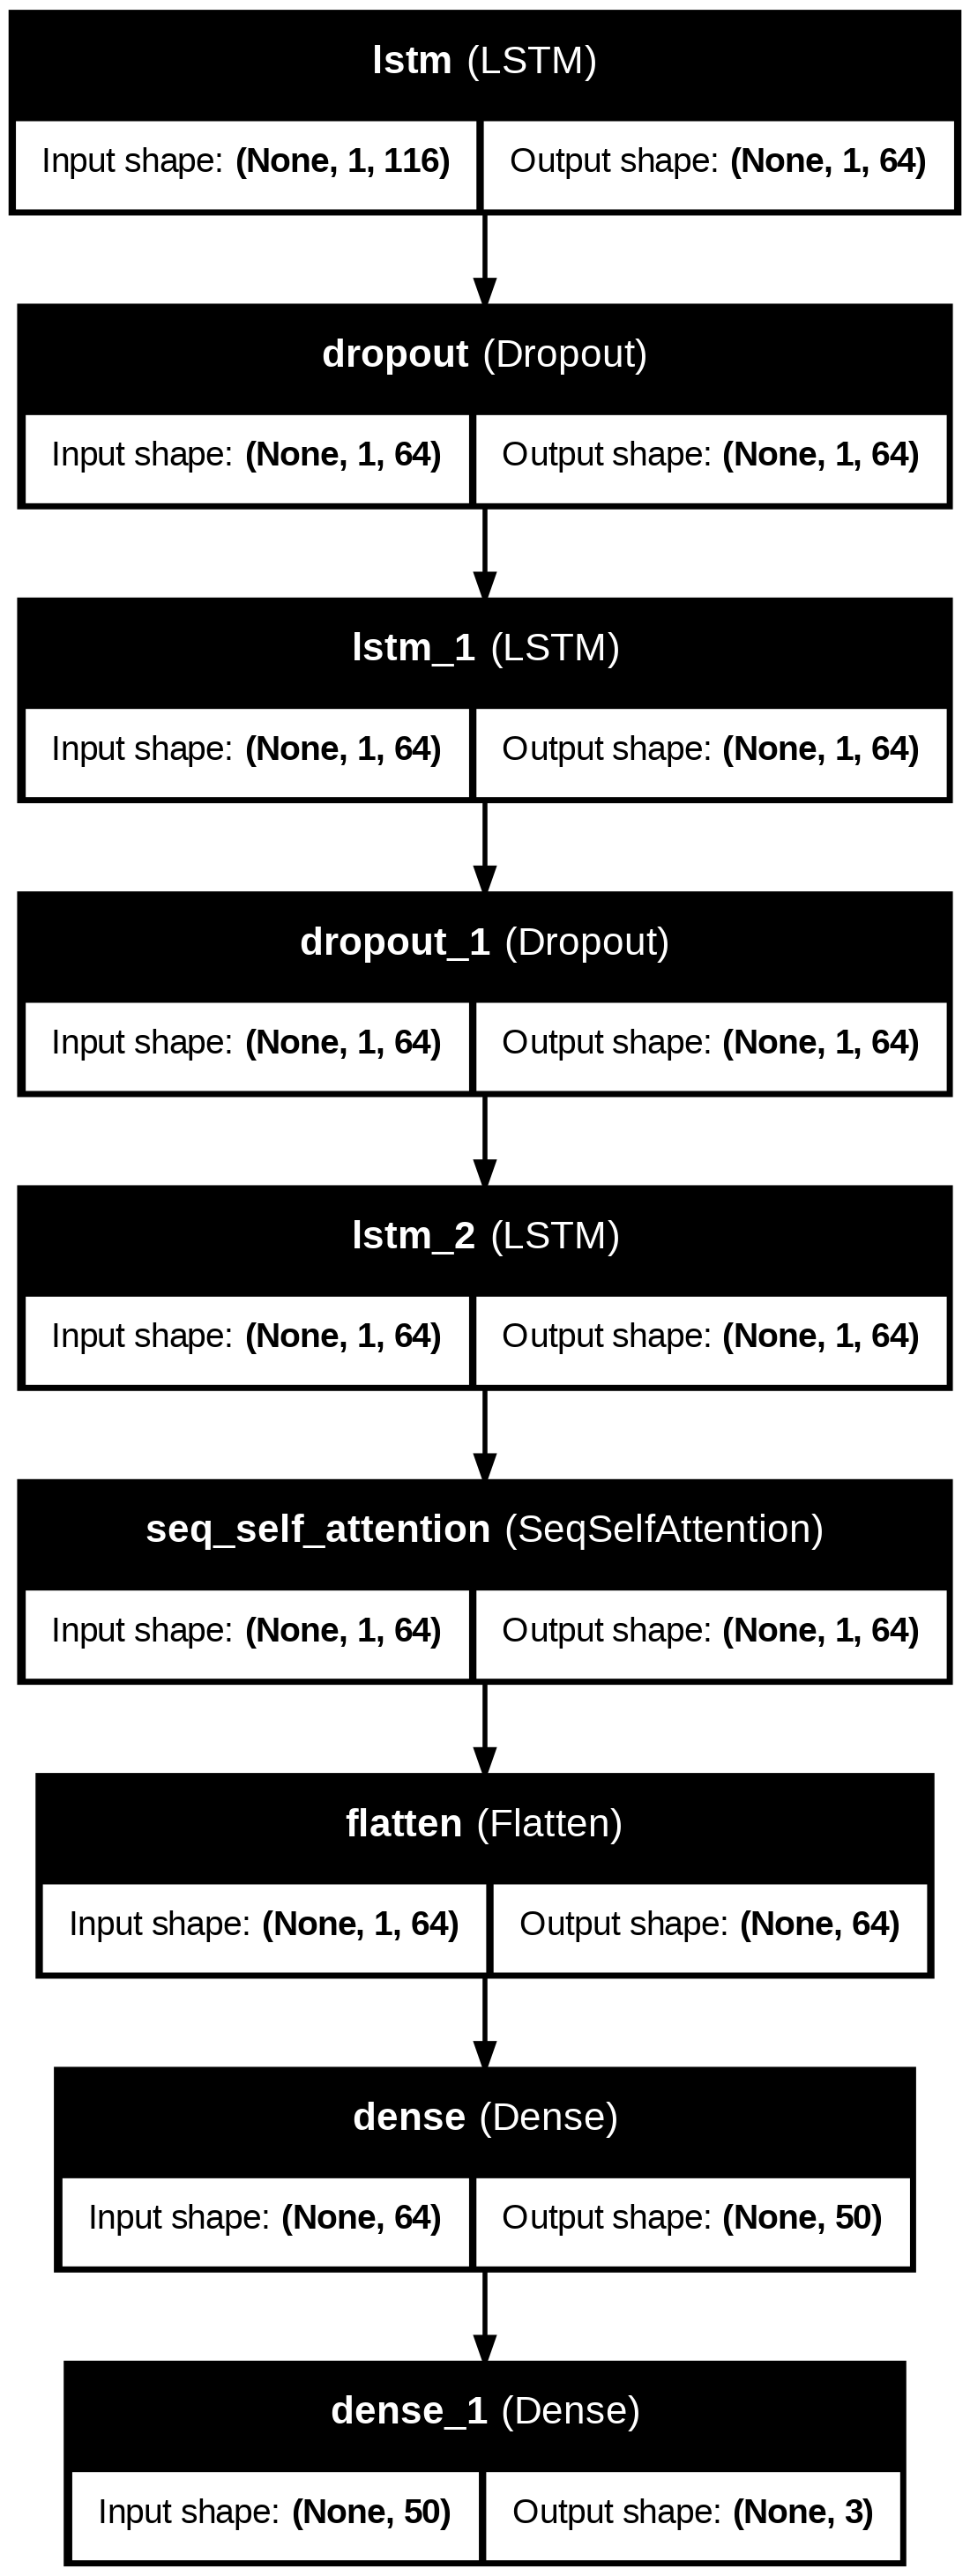

In [27]:
#Visualize the model

from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [28]:
X_train = X_train.astype(float)
print(X_train.shape)
y_train = y_train.astype(float)
print(y_train.shape)

(155973, 1, 116)
(155973, 3)


In [29]:
# training the model on training dataset
history = model.fit(X_train, y_train, epochs=50, batch_size=5000,validation_split=0.2)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 282ms/step - accuracy: 0.6223 - loss: 0.6724 - precision: 0.3784 - recall: 0.0105 - val_accuracy: 0.0331 - val_loss: 0.7379 - val_precision: 0.3170 - val_recall: 0.0190
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.8579 - loss: 0.4412 - precision: 0.9028 - recall: 0.6188 - val_accuracy: 0.0339 - val_loss: 0.9472 - val_precision: 0.0378 - val_recall: 0.0338
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.8831 - loss: 0.1912 - precision: 0.9066 - recall: 0.8758 - val_accuracy: 0.0376 - val_loss: 1.4156 - val_precision: 0.0390 - val_recall: 0.0342
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.9245 - loss: 0.1352 - precision: 0.9441 - recall: 0.9065 - val_accuracy: 0.1276 - val_loss: 1.4647 - val_precision: 0.1010 - val_recall: 0.0881
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9584 - loss: 0.1041 - precision: 0.9630 - recall: 0.9533 - val_accuracy: 0.2699 - val_loss: 1

In [30]:
X_test = X_test.astype(float)
y_test = y_test.astype(float)

In [31]:
# predicting target attribute on testing dataset
test_results = model.evaluate(X_test, y_test,verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7774 - loss: 0.9761 - precision: 0.7776 - recall: 0.7773
Test results - Loss: 0.9805466532707214 - Accuracy: 77.63041257858276%


In [32]:
results = model.evaluate(X_test, y_test,batch_size = 128)

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7774 - loss: 0.9753 - precision: 0.7776 - recall: 0.7773


In [33]:
print(model.metrics_names)
print(results)

['loss', 'compile_metrics']
[0.9805467128753662, 0.7763041257858276, 0.7765744924545288, 0.7761266827583313]


Text(0.5, 0, 'Epochs')

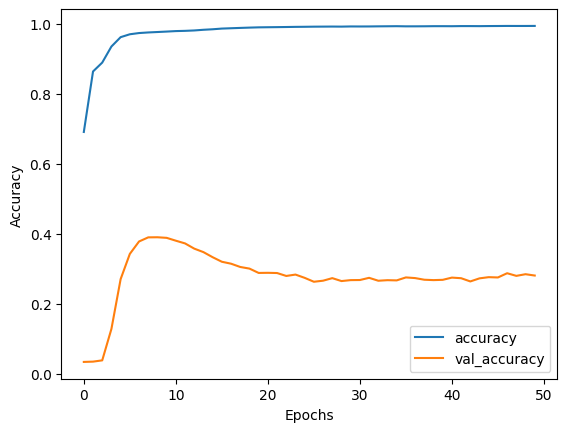

In [34]:
# # Plot of accuracy vs epoch for train and test dataset
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title("Plot of accuracy vs epoch for train and test dataset")
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.show()
pd.DataFrame(history.history)
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

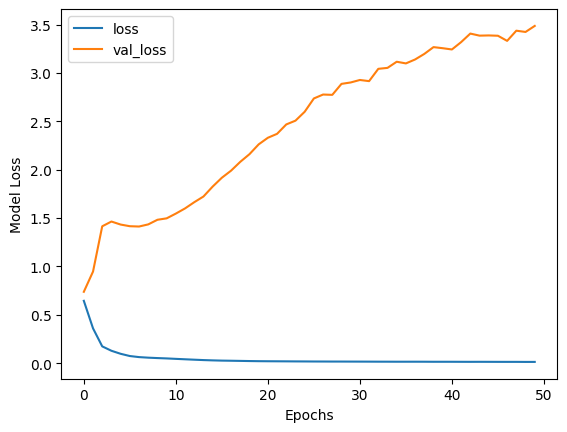

In [35]:
# # Plot of loss vs epoch for train and test dataset
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title("Plot of loss vs epoch for train and test dataset")
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
# plt.show()
pd.DataFrame(history.history)
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.ylabel('Model Loss')
plt.xlabel('Epochs')

In [36]:
from sklearn.metrics import classification_report

y_predict = model.predict(X_test)
y_pred = y_predict.argmax(axis=-1)
y_test = y_test.argmax(axis = -1 )
report = classification_report(y_test, y_pred)
print(report)
print(y_pred)
df1 = pd.DataFrame(y_pred)
# saving the dataframe
df1.to_csv('/content/drive/MyDrive/DLC-IDS/Outputs/CP.csv', index = False)

705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
              precision    recall  f1-score   support

           0       0.90      0.68      0.78     10412
           1       0.72      0.69      0.71      2421
           2       0.71      0.90      0.79      9711

    accuracy                           0.78     22544
   macro avg       0.78      0.76      0.76     22544
weighted avg       0.80      0.78      0.78     22544

[0 0 2 ... 0 2 1]


Confusion Matrix:
 [[7097  145 3170]
 [ 315 1668  438]
 [ 484  491 8736]]


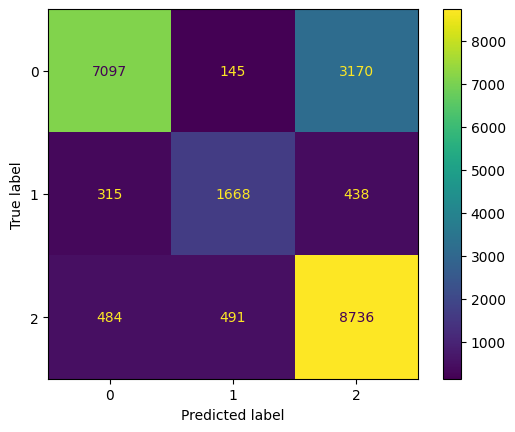

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# create a ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(cm)
# plot the confusion matrix
print("Confusion Matrix:\n", cm)
cm_display.plot()
plt.show()

In [38]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

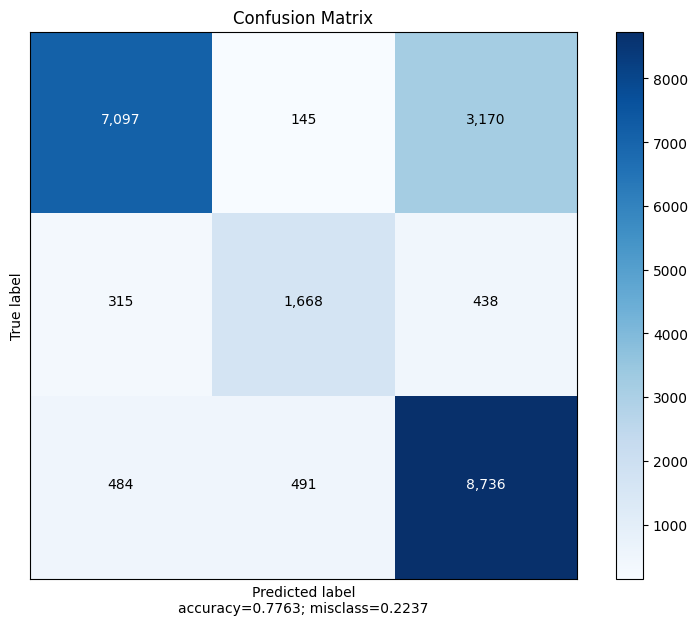

In [39]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(cm=confusion_matrix(y_test, y_pred),
                      normalize=False,
                      target_names=[],
                      title="Confusion Matrix")

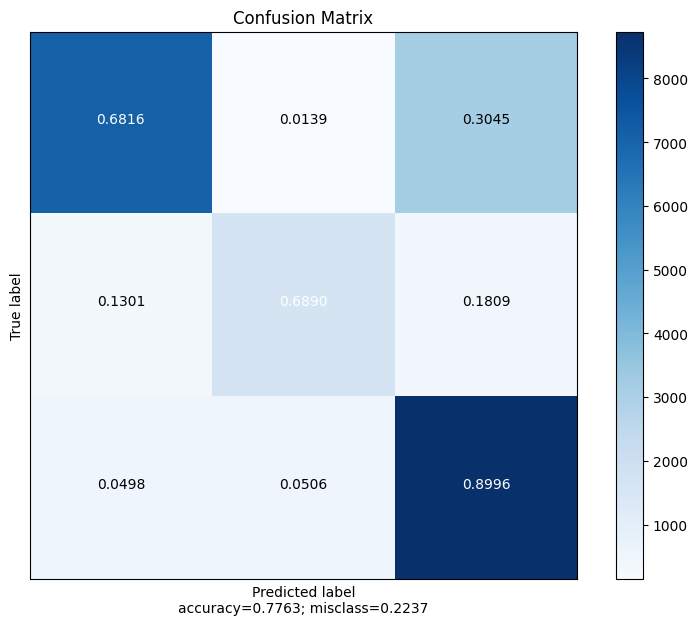

In [40]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(cm=confusion_matrix(y_test, y_pred),
                      normalize=True,
                      target_names=[],
                      title="Confusion Matrix")

In [41]:
model.save("NSL-KDD LSTM.h5")